In this notebook, I explore the use of geopandas. 

In [6]:
import folium
from folium.features import GeoJsonTooltip
import fiona
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import geopandas.tools
from geopandas.tools import geocode
from shapely.geometry import Point, Polygon

In [2]:
stations_2011 = pd.read_csv('cleaned_data/stations_2011.csv')

In [3]:
stations_2011.head(2)

,station,region,lat,lon
0,5th & F St NW,"Washington, DC",38.897222,-77.019347
1,14th & Harvard St NW,"Washington, DC",38.926800,-77.032200


In [13]:
df_2011 = pd.read_csv('cleaned_data/df_2011.csv')

In [16]:
# Create dataframe of start stations, sorted by number of uses.
df_2011_start = pd.DataFrame(df_2011.groupby('start_station').count()['duration']).rename(columns = {'duration': 'count'}).sort_values(by = 'count', ascending=False).reset_index()

In [17]:
df_2011_start.head()

,start_station,count
0,Massachusetts Ave & Dupont Circle NW,49093
1,15th & P St NW,32884
2,Columbus Circle / Union Station,32058
3,Adams Mill & Columbia Rd NW,29964
4,17th & Corcoran St NW,28160


In [18]:
# Create dataframe of end stations, sorted by number of uses.
df_2011_end = pd.DataFrame(df_2011.groupby('end_station').count()['duration']).rename(columns = {'duration': 'count'}).sort_values(by = 'count', ascending=False).reset_index()


In [19]:
df_2011_end.head()

,end_station,count
0,Massachusetts Ave & Dupont Circle NW,53910
1,15th & P St NW,36638
2,Columbus Circle / Union Station,32252
3,17th & Corcoran St NW,29103
4,Adams Mill & Columbia Rd NW,26248


In [20]:
# Now merge "stations_2011" with "df_2011_start" and "df_2011_end"

stations_2011 = stations_2011.merge(df_2011_start, how = 'left', left_on = 'station', right_on = 'start_station')
stations_2011.rename(columns = {'count': 'start_count'}, inplace = True)
stations_2011 = stations_2011.merge(df_2011_end, how = 'left', left_on = 'station', right_on = 'end_station')
stations_2011.rename(columns = {'count': 'end_count'}, inplace = True)

In [21]:
stations_2011.drop(['start_station', 'end_station'], axis = 1, inplace = True)

In [22]:
stations_2011.head()

,station,region,lat,lon,geometry,start_count,end_count
0,5th & F St NW,"Washington, DC",38.897222,-77.019347,POINT (-77.01935 38.89722),14942,16137
1,14th & Harvard St NW,"Washington, DC",38.926800,-77.032200,POINT (-77.03220 38.92680),17507,12877
2,Georgia & New Hampshire Ave NW,"Washington, DC",38.936684,-77.024181,POINT (-77.02418 38.93668),10045,7308
3,10th & U St NW,"Washington, DC",38.917200,-77.025900,POINT (-77.02590 38.91720),16737,17247
4,Adams Mill & Columbia Rd NW,"Washington, DC",38.922925,-77.042581,POINT (-77.04258 38.92292),29964,26248


In [23]:
# Create GeoDataFrame based on stations_2011. Add geo-coordinates.
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(stations_2011['lon'], stations_2011['lat'])]
geo_stations_2011 = gpd.GeoDataFrame(stations_2011,crs = crs, geometry = geometry)

/opt/anaconda3/envs/geo_pandas_new/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [25]:
# Import maps for DC, Arlington, and Alexandria
# The shape files were downloaded from opendata.dc.gov

gdf1 = gpd.read_file('shp_files/washington_dc/Washington_DC_Boundary.shp')
gdf2 = gpd.read_file('shp_files/arlington/County_poly.shp')
gdf3 = gpd.read_file('shp_files/alexandria/Boundary.shp')

# Convert CRS
gdf1 = gdf1.to_crs(epsg=4326)
gdf2 = gdf2.to_crs(epsg=4326)
gdf3 = gdf3.to_crs(epsg=4326)

# Concatenate into a single geodataframe
gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3]))

<AxesSubplot:>

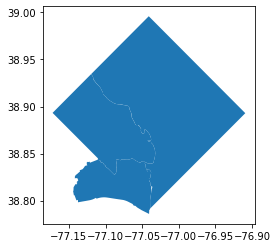

In [26]:
gdf.plot()

In [27]:
# Import shape file for bike trails
dc_bike_trails = gpd.read_file('shp_files/washington_dc/bike_trails/Bike_Trails.shp')

# Convert CRS
dc_bike_trails = dc_bike_trails.to_crs(epsg=4326)

<AxesSubplot:>

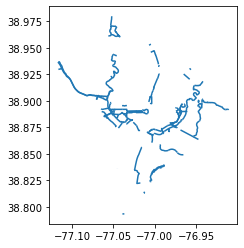

In [28]:
dc_bike_trails.plot()

In [29]:
# Import file for DC metro stations
dc_metro_stops = gpd.read_file('shp_files/washington_dc/metro_stations/Metro_Stations_Regional.shp')

# Convert CRS
dc_metro_stops = dc_metro_stops.to_crs(epsg=4326)


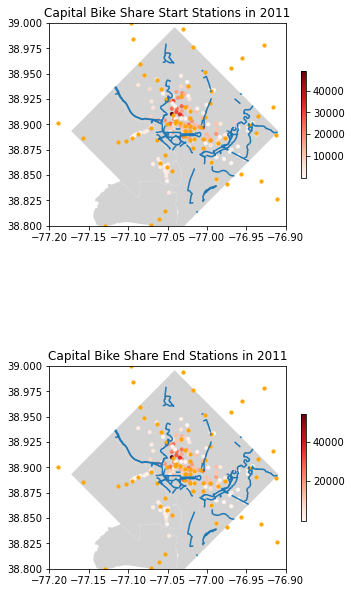

In [30]:
# Plot start and end stations over the various maps. 
# Colours are determined by number of trips per station.

fig, ax = plt.subplots(2,1, figsize = (5,10))
gdf.to_crs(epsg=4326).plot(ax=ax[0], color='lightgrey')
geo_stations_2011.plot(column = 'start_count', ax=ax[0], cmap = 'Reds', legend = True, legend_kwds={'shrink': 0.3}, markersize = 10)
dc_bike_trails.plot(ax = ax[0])
dc_metro_stops.plot(ax = ax[0], c = 'orange', markersize = 10)
ax[0].set_title('Capital Bike Share Start Stations in 2011')
ax[0].set_xlim([-77.2, -76.9])
ax[0].set_ylim([38.8, 39])

gdf.to_crs(epsg=4326).plot(ax=ax[1], color='lightgrey')
geo_stations_2011.plot(column = 'end_count', ax=ax[1], cmap = 'Reds', legend = True, legend_kwds={'shrink': 0.3}, markersize = 10)
dc_bike_trails.plot(ax = ax[1])
dc_metro_stops.plot(ax = ax[1], c = 'orange', markersize = 10)
ax[1].set_title('Capital Bike Share End Stations in 2011')
ax[1].set_xlim([-77.2, -76.9])
ax[1].set_ylim([38.8, 39])

plt.tight_layout()
plt.show()